# 1. Imports

In [2]:
import re
import string
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    DistilBertConfig,
    get_scheduler
)
import optuna
import json

2025-03-03 20:10:13.110257: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 20:10:32.722736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-03 20:10:50.460709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

# 2. Data Preprocessing

In [4]:
def load_and_preprocess_data():
    df = pd.read_csv('glassdoor_datasets/best_all_it_jobs.csv')
    columns_to_keep = ['review_text', 'sentiment']
    df = df[columns_to_keep].dropna(subset=['review_text'])
    
    label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
    df['label'] = df['sentiment'].map(label_map)

    df_sampled = (df.groupby("sentiment")
                  .sample(n=25000, random_state=SEED, replace=True)
                  .reset_index(drop=True))
    
    print("=== Sample reviews (raw) ===")
    print(df_sampled['review_text'].head(3).to_list())

    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    df_sampled['cleaned_review'] = df_sampled['review_text'].apply(clean_text)
    print("\n=== Sample reviews (cleaned) ===")
    print(df_sampled['cleaned_review'].head(3).to_list())
    return df_sampled


df_sampled = load_and_preprocess_data()

=== Sample reviews (raw) ===
["**Company To AVOID** Disgusting management, 0 structure in the company, toxic CEO Remote working ( and when you start to know the boss, you understand why it's better like that ) The CEO. Certified bad boss, I invite you to do research on the guy and you'll understand the pattern, it's not his first company that crash because of big turnover and inexistent customer support. He's known by lawyers in Tel Aviv as much as his employees attack him in court. Strictly no opportunity for growth in this company, and the pay is anyway not attractive with no more than 12 days of holidays a year. He still didn't pay me the pension that he owe me. Real lunatic , you'll need a lot of patience and self control to handle the Ceo", 'Software engineer Immense opportunity to learn and ownership of projects end to end No work life balance and no wfh options and 45hrs/week strict criteria', 'Not a very good environment to work 1. transport is good\r\n2. food provided by compa

# 3. Tokenization

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(df, max_length=256):
    return tokenizer(
        text=df['cleaned_review'].tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt',
        add_special_tokens=True,
        return_attention_mask=True,
        return_token_type_ids=False
    )

tokenized = tokenize_data(df_sampled)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']
labels = torch.tensor(df_sampled['label'].values, dtype=torch.long)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

# 4. Data Splitting


In [6]:
def stratified_split(inputs, masks, labels, test_size=0.3):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=SEED)
    train_idx, temp_idx = next(sss.split(inputs, labels))
    return (inputs[train_idx], masks[train_idx], labels[train_idx]), \
           (inputs[temp_idx], masks[temp_idx], labels[temp_idx])

(train_inputs, train_masks, train_labels), (temp_inputs, temp_masks, temp_labels) = stratified_split(input_ids, attention_mask, labels)
(val_inputs, val_masks, val_labels), (test_inputs, test_masks, test_labels) = stratified_split(temp_inputs, temp_masks, temp_labels, test_size=0.5)

# 5. DataLoader

In [7]:
def create_dataloader(inputs, masks, labels, batch_size, shuffle=False):
    return DataLoader(
        TensorDataset(inputs, masks, labels),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2
    )

# 6. Training Function

In [ ]:
def train(model, train_loader, optimizer, scheduler, params, device):
    model.train()
    total_loss = 0
    scaler = torch.cuda.amp.GradScaler()
    optimizer.zero_grad()
    for step, batch in enumerate(tqdm(train_loader, desc="Training")):
        inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs, attention_mask=masks, labels=lbls)
            loss = outputs.loss / params['grad_accum_steps']
        scaler.scale(loss).backward()
        if (step + 1) % params['grad_accum_steps'] == 0:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), params['grad_clip'])
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
        total_loss += loss.item() * params['grad_accum_steps']
    return total_loss / len(train_loader)

# 7. Evaluation Function

In [8]:
def evaluate(model, val_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
        for batch in val_loader:
            inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
            logits = model(inputs, attention_mask=masks).logits
            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    return acc, f1, precision, recall

In [9]:
def evaluate_with_metrics(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
        for batch in test_loader:
            inputs, masks, lbls = [t.to(device, non_blocking=True) for t in batch]
            logits = model(inputs, attention_mask=masks).logits
            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    return cm, acc, f1, precision, recall

# 8. Hyperparameter Tuning with Optuna

In [ ]:
USE_OPTUNA = False

default_params = {
    'lr': 3e-5,
    'weight_decay': 1e-5,
    'num_epochs': 5,
    'hidden_dropout': 0.3,
    'attention_dropout': 0.3,
    'batch_size': 32,
    'grad_clip': 1.0,
    'grad_accum_steps': 1
}

In [11]:
def run_optuna(train_inputs, train_masks, train_labels, val_inputs, val_masks, val_labels, device):
    def objective(trial):
        params = {
            'lr': trial.suggest_float('lr', 1e-5, 5e-5, log=True),
            'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True),
            'num_epochs': trial.suggest_int('num_epochs', 5, 10),
            'hidden_dropout': trial.suggest_float('hidden_dropout', 0.2, 0.4),
            'attention_dropout': trial.suggest_float('attention_dropout', 0.2, 0.4),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
            'grad_clip': trial.suggest_float('grad_clip', 0.5, 1.5),
            'grad_accum_steps': trial.suggest_int('grad_accum_steps', 1, 2)
        }

        print(f"\n--- Starting trial with params: {params} ---")
        train_loader = create_dataloader(train_inputs, train_masks, train_labels, params['batch_size'], shuffle=True)
        val_loader = create_dataloader(val_inputs, val_masks, val_labels, params['batch_size'])

        config = DistilBertConfig.from_pretrained(
            'distilbert-base-uncased',
            num_labels=3,
            hidden_dropout_prob=params['hidden_dropout'],
            attention_probs_dropout_prob=params['attention_dropout']
        )
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config).to(device)

        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        total_steps = (len(train_loader) // params['grad_accum_steps']) * params['num_epochs']
        scheduler = get_scheduler('linear', optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)

        best_f1 = 0
        for epoch in range(params['num_epochs']):
            train(model, train_loader, optimizer, scheduler, params, device)
            acc, f1, _, _ = evaluate(model, val_loader, device)
            print(f"Trial {trial.number}, Epoch {epoch+1}/{params['num_epochs']} - Val Acc: {acc:.4f}, Val F1: {f1:.4f}")
            trial.report(f1, epoch)
            if trial.should_prune():
                print("Trial pruned!")
                raise optuna.TrialPruned()
            best_f1 = max(best_f1, f1)

        print(f"Trial {trial.number} finished with best validation F1: {best_f1:.4f}")
        return best_f1


    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=SEED),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=1)
    )
    study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)
    best_params = study.best_params.copy()
    print("\nBest Hyperparameters Found:")
    print(best_params)
    return best_params

# 9. Final Training with Best Parameters

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

df_sampled = load_and_preprocess_data()
tokenized = tokenize_data(df_sampled)
input_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']
labels = torch.tensor(df_sampled['label'].values, dtype=torch.long)

(train_inputs, train_masks, train_labels), (temp_inputs, temp_masks, temp_labels) = stratified_split(input_ids, attention_mask, labels)
(val_inputs, val_masks, val_labels), (test_inputs, test_masks, test_labels) = stratified_split(temp_inputs, temp_masks, temp_labels, test_size=0.5)

if USE_OPTUNA:
    best_params = run_optuna(train_inputs, train_masks, train_labels, val_inputs, val_masks, val_labels, device)
    with open("best_params_bert.json", "w") as f:
        json.dump(best_params, f)
    print("Best hyperparameters saved to best_params_bert.json.")
else:
    try:
        with open("best_params_bert.json", "r") as f:
            best_params = json.load(f)
        print("Loaded hyperparameters from best_params_bert.json:")
        print(best_params)
    except FileNotFoundError:
        best_params = default_params
        print("\nUsing default hyperparameters:")
        print(best_params)

Using device: cuda
=== Sample reviews (raw) ===
["**Company To AVOID** Disgusting management, 0 structure in the company, toxic CEO Remote working ( and when you start to know the boss, you understand why it's better like that ) The CEO. Certified bad boss, I invite you to do research on the guy and you'll understand the pattern, it's not his first company that crash because of big turnover and inexistent customer support. He's known by lawyers in Tel Aviv as much as his employees attack him in court. Strictly no opportunity for growth in this company, and the pay is anyway not attractive with no more than 12 days of holidays a year. He still didn't pay me the pension that he owe me. Real lunatic , you'll need a lot of patience and self control to handle the Ceo", 'Software engineer Immense opportunity to learn and ownership of projects end to end No work life balance and no wfh options and 45hrs/week strict criteria', 'Not a very good environment to work 1. transport is good\r\n2. foo

In [ ]:
train_loader = create_dataloader(train_inputs, train_masks, train_labels, best_params['batch_size'], shuffle=True)
val_loader = create_dataloader(val_inputs, val_masks, val_labels, best_params['batch_size'])
test_loader = create_dataloader(test_inputs, test_masks, test_labels, best_params['batch_size'])

config = DistilBertConfig.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    hidden_dropout_prob=best_params['hidden_dropout'],
    attention_probs_dropout_prob=best_params['attention_dropout']
)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config).to(device)

optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
total_steps = (len(train_loader) // best_params['grad_accum_steps']) * best_params['num_epochs']
scheduler = get_scheduler('linear', optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)

In [13]:
train_losses = []
val_accuracies = []
val_f1_scores = []
best_val_f1 = 0
patience_counter = 0

for epoch in range(best_params['num_epochs']):
    train_loss = train(model, train_loader, optimizer, scheduler, best_params, device)
    train_losses.append(train_loss)
    
    acc, f1, _, _ = evaluate(model, val_loader, device)
    val_accuracies.append(acc)
    val_f1_scores.append(f1)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Acc = {acc:.4f}, Val F1 = {f1:.4f}")
    
    if f1 > best_val_f1:
        best_val_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_uncased_bert_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= 3:
            print("Early stopping triggered")
            break

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/1641 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.6244, Val Acc = 0.8282, Val F1 = 0.8286


Training:   0%|          | 0/1641 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.3960, Val Acc = 0.8546, Val F1 = 0.8550


Training:   0%|          | 0/1641 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.2724, Val Acc = 0.8716, Val F1 = 0.8721


Training:   0%|          | 0/1641 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0902fe5160>
Traceback (most recent call last):
  File "/usr/local/lib64/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib64/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib64/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
: AssertionErrorcan only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0902fe5160>
Traceback (most recent call last):
  File "/usr/local/lib64/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib64/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr

Epoch 4: Train Loss = 0.1742, Val Acc = 0.8688, Val F1 = 0.8683


Training:   0%|          | 0/1641 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.1144, Val Acc = 0.8789, Val F1 = 0.8790


Training:   0%|          | 0/1641 [00:00<?, ?it/s]

Epoch 6: Train Loss = 0.0700, Val Acc = 0.8808, Val F1 = 0.8808


# 10. Training Graphs

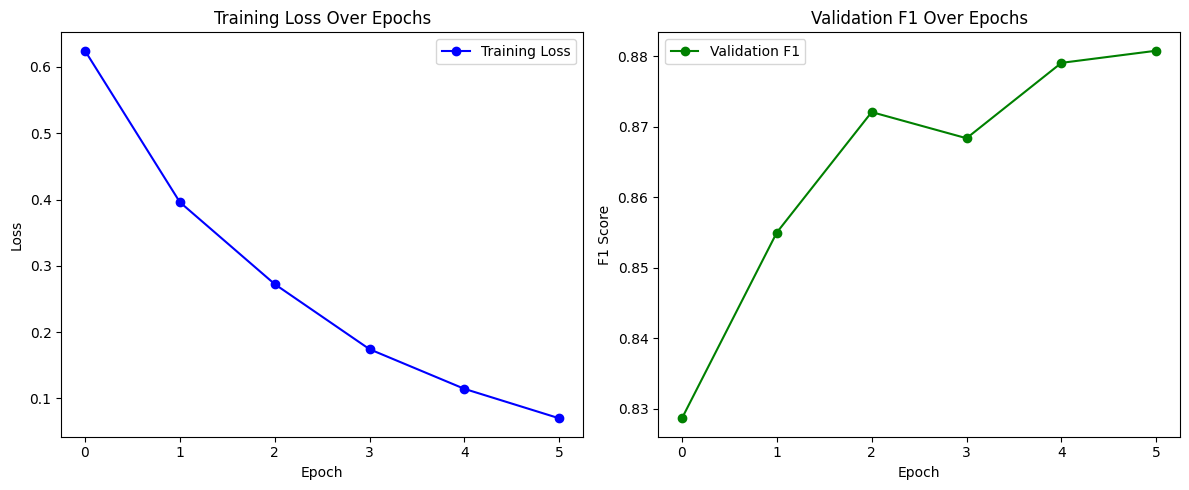

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_f1_scores, label='Validation F1', color='green', marker='o')
plt.title('Validation F1 Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# 11. Final Evaluation

Test Accuracy: 0.8828
Test Precision: 0.8837
Test Recall: 0.8828
Test F1 Score: 0.8827


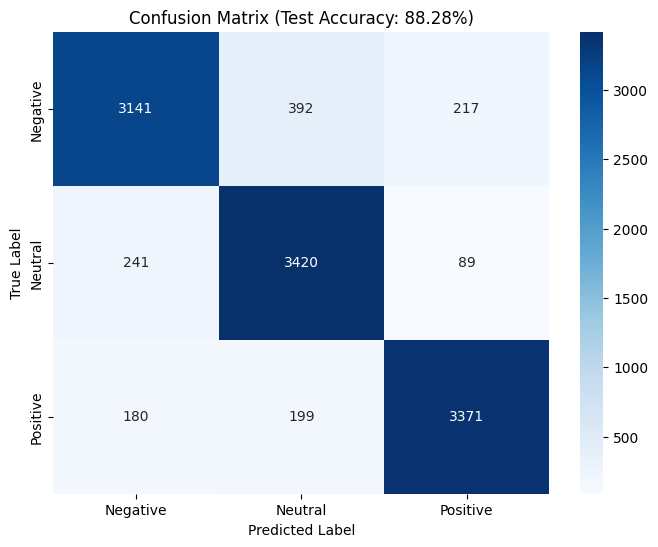

In [15]:
model.load_state_dict(torch.load('best_uncased_bert_model.pth'))
cm, test_acc, test_f1, test_precision, test_recall = evaluate_with_metrics(model, test_loader, device)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'Confusion Matrix (Test Accuracy: {test_acc:.2%})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 12. Save Model

In [16]:
model.save_pretrained('distil_bert_model_data')
tokenizer.save_pretrained('distil_bert_model_data')

('best_uncased_bert_model_data2/tokenizer_config.json',
 'best_uncased_bert_model_data2/special_tokens_map.json',
 'best_uncased_bert_model_data2/vocab.txt',
 'best_uncased_bert_model_data2/added_tokens.json')